Style GAN

In [65]:
#import stuff
#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten, Conv2D, LeakyReLU, AveragePooling2D, Add, Input, InputSpec, UpSampling2D, Activation, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.optimizers import *
from tensorflow.python.keras.utils import conv_utils
#other stuff
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from IPython import display
import math

Parameters

In [66]:
batch_size = 32
depth = 16          #filters
latent_size = 64    #size of input vector z
im_size = 28        #final image size
n_layers = 8        #no. layers in the synthesis network

Load and process the data

In [67]:
#load raw data
(raw_ds, labels), _ = tf.keras.datasets.mnist.load_data()
raw_ds = raw_ds.reshape(raw_ds.shape[0], 28, 28, 1).astype('float32')
print(raw_ds.shape)
#check range of raw_ds
print(np.min(raw_ds[0]), np.max(raw_ds[0]))

#normalise data
norm_ds = raw_ds/255
#norm_ds = (raw_ds - 127.5) / 127.5
print(np.min(norm_ds[0]), np.max(norm_ds[0]))

#batch and shuffle the dataset
norm_ds = tf.data.Dataset.from_tensor_slices(norm_ds).shuffle(norm_ds.shape[0]).batch(batch_size)
print(norm_ds)

(60000, 28, 28, 1)
0.0 255.0
0.0 1.0
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


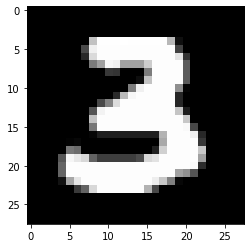

In [68]:
#visualise dataset
for images in norm_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"), cmap='gray')
    plt.show()

Networks

In [69]:
#Conv2DMod layer
#https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0/blob/989306792ca49dcbebb353c4f06c7b48aeb3a9e3/conv_mod.py#L15

class ModConv2D (keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1,1), padding = 'valid', kernel_initializer='glorot_uniform', 
                    kernel_regularizer=None, activity_regularizer=None, kernel_constraint=None, demod = True, **kwargs):
        #define all the parameters of the layer
        super(ModConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.rank = 2
        self.kernel_size= conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        #?
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        #?
        self.demod = demod

        #input with ndim=4 is previous convolution layer
        #input with ndim=2 is the input style for this layer (output from style generator)
        self.Input_spec = [InputSpec(ndim=4), InputSpec(ndim=2)]


    def build(self, input_shape):
        #define weights after shape of input is known
        channel_axis = -1
        input_dim = input_shape[0][channel_axis] #should be 1 for this dataset since it's only grayscale images being sent through the system
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape, initializer=self.kernel_initializer, name='kernel', 
                                        regularizer=self.kernel_regularizer, constraint=self.kernel_constraint)

        #input specifications
        #input_shape[0] is the output of the previous layer
        #input_shape[1] is the style
        self.input_spec = [InputSpec(ndim=4, axes={channel_axis: input_dim}), InputSpec(ndim=2)]

        self.built = True


    def call(self, inputs):
        #execute the code when the layer is used
            #modulation stuff
        style = inputs[1]
        #print("style shape:", style.shape)
        #print("kernel shape:", self.kernel.shape)

        #make the input style W shape compatible with kernel
        inp_mods = K.expand_dims(K.expand_dims(K.expand_dims(style, axis = 1), axis = 1), axis = -1)
        my_kernel = K.expand_dims(self.kernel, axis=0)

        #modulate
        #print("kernel", (int)(tf.rank(my_kernel)), my_kernel.shape)
        #print("kernel shape:", my_kernel.shape)
        #print("input style", (int)(tf.rank(inp_mods)), inp_mods.shape)
        #print("input style shape:", inp_mods.shape)
        weights = my_kernel * (inp_mods + 1)
        #weights = 0

        #demodulate
        if self.demod:
            weights /= K.sqrt(K.sum(K.square(weights), axis=[1,2,3], keepdims = True) + 1e-8)
        
        x = tf.transpose(inputs[0], [0,3,1,2])
        x = tf.reshape(x, [1, -1, x.shape[2], x.shape[3]])

        w = tf.transpose(weights, [1,2,3,0,4])
        w = tf.reshape(w, [weights.shape[1], weights.shape[2], weights.shape[3], -1])

        #normal convolution 2d
        #data is stored in [batch_size, channels, height, width]
        x = tf.nn.conv2d(x, w, strides=self.strides, padding='SAME', data_format='NCHW')

        #print(x.shape)

        x = tf.reshape(x, [-1, self.filters, tf.shape(x)[2], tf.shape(x)[3]]) # Fused => reshape convolution groups back to minibatch.
        x = tf.transpose(x, [0, 2, 3, 1])

        return x

In [70]:
#define generator
#mapping network
    #for taking an image (style) and converting it to latent space to use in the weights of the synthesis network
#synthesis network
    #network used to generate images using input style and noise
    #skip connections

#https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0/blob/master/stylegan_two.py

def noise(n):
    return np.random.normal(0.0, 1.0, size = [n, latent_size]).astype('float32')

''' def noiseList(n):
    noise_list = []
    for i in range(n_layers):
        noise_list.append(noise(n))
    return noise_list '''

def noiseList(n):
    return [noise(n)] * n_layers

def crop_to_fit(x):
    #makes sure that x[0] has the same dimensions as x[1]
    height = x[1].shape[1]
    width = x[1].shape[2]

    return x[0][:, :height, :width, :]

def make_output_size(s1=4, s2=im_size):
    ss = int(s2 / s1)
    #print(ss)
    def upsample_to_size(x, y = ss):
        x = K.resize_images(x, y, y, "channels_last", interpolation='bilinear')
        #print(x.shape)
        return x
    return upsample_to_size

def to_output(inputs, style):
    #want to do a ModConv2D on input with styles like norma;
    size = inputs.shape[2]
    #print(inputs.shape, size)
    x = ModConv2D(1, 1, kernel_initializer=VarianceScaling(200/size), demod=False)([inputs, style])
    #upsample image to be (None, im_size, im_size, None)
    #print(x.shape)
    return Lambda(make_output_size(size, im_size), output_shape=[None, im_size, im_size, None])(x)

def make_style_generator():
    #standard deep NN
    model = tf.keras.Sequential()
    model.add(Dense(512, input_shape=[latent_size]))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))

    return model

def g_block(inputs, input_style, input_noise, filters, upsampling=True):

    #optional upsampling
    if upsampling:
        out = UpSampling2D(interpolation='bilinear')(inputs)
    else:
        out = Activation('linear')(inputs)

    #residual
    out_style = Dense(filters, kernel_initializer = VarianceScaling(200/out.shape[2]))(input_style)

    #main block
    #style stuff
    style = Dense(inputs.shape[-1], kernel_initializer = 'he_uniform')(input_style)
    delta = Lambda(crop_to_fit)([input_noise, out])
    d = Dense(filters, kernel_initializer='zeros')(delta)

    #ModConv2D block
    out = ModConv2D(filters, (3,3), strides=(1,1), padding="same", kernel_initializer = 'he_uniform')([out, style])
    out = Add()([out, d])
    out = LeakyReLU(0.2)(out)

    return out, to_output(out, out_style)


def make_synthesis_network ():
    #Inputs
    input_styles = []
    #input_noises = []
    for i in range(n_layers):
        input_styles.append(Input(shape=[512]))

    input_noise = Input(shape=[im_size, im_size, 1])
    # x = tf.random.normal([batch_size, 4, 4 , 4*depth])
    outs = []

    x = Lambda(lambda x: x[:, :1]*0 + 1)(input_styles[0])
    x = tf.ones([batch_size, 1]) #c
    # print(input_styles[0].shape)
    # print(x.shape)

    x = Dense(7*7*4*depth, activation='relu', kernel_initializer='random_normal')(x) #learned c
    x = Reshape([7, 7, 4*depth])(x)

    x, r = g_block(x, input_styles[1], input_noise, 4*depth, upsampling=False)    #7x7
    outs.append(r)
    #print(x.shape) #, r.shape)
    x, r = g_block(x, input_styles[2], input_noise, 2*depth)                      #14x14
    outs.append(r)
    #print(x.shape) #, r.shape)
    x, r = g_block(x, input_styles[3], input_noise, depth)                      #28x28
    outs.append(r)
    #print(x.shape) #, r.shape)
    
    """ 
    """

    x = Add()(outs)

    #normalise
    x = Lambda(lambda y: y/2 + 0.5)(x) #range ?

    #print("end shape", x.shape)
    
    model = Model(inputs = [input_styles, input_noise], outputs = x)
    return model

def make_generator_model(S, G):
    input_z = []
    W = []
    for i in range(n_layers):
        input_z.append(Input([latent_size]))
        W.append(S(input_z[-1]))

    input_noise = Input([im_size, im_size, 1])

    generated_image = G((W, input_noise))
    
    gen_model = Model(inputs = [input_z, input_noise], outputs = generated_image)

    return gen_model

In [71]:
x = tf.random.normal([3,64])
print(x.shape)
x = Lambda(lambda x: x[:, :1]*0 + 1)(x)
print(x)

(3, 64)
tf.Tensor(
[[1.]
 [1.]
 [1.]], shape=(3, 1), dtype=float32)


In [72]:
#make generator model
S = make_style_generator()
G = make_synthesis_network()

gen_model = make_generator_model(S, G)

#gen_model.summary()

In [73]:
gen_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 64)]         0                                            
____________________________________________________________________________________________

(32, 28, 28, 1)


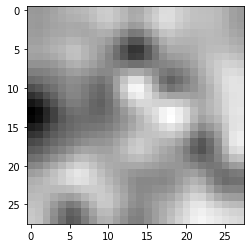

In [74]:
z = noiseList(batch_size)
w = []
for i in range(n_layers):
    w.append(S(z[i]))

added_noise = tf.random.normal((batch_size, im_size, im_size, 1))
image = G((w, added_noise))
print(image.shape)
plt.imshow(image[0].numpy().astype("float32"), cmap='gray')

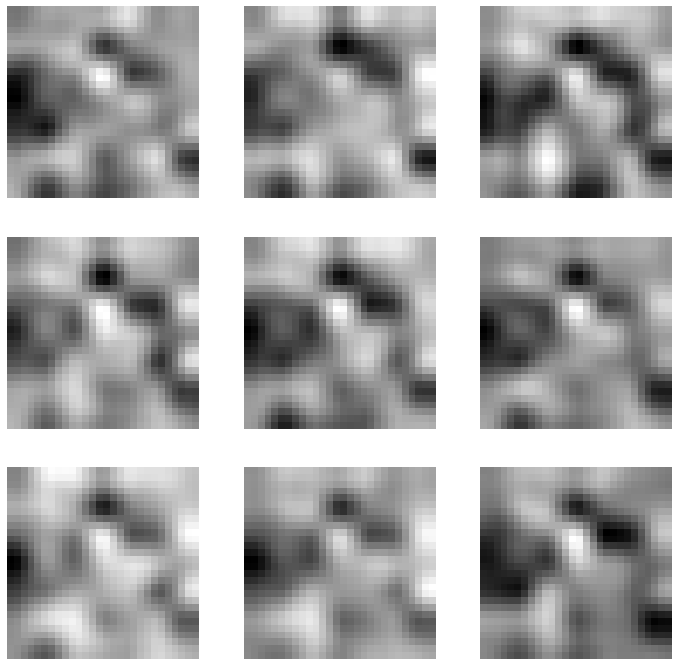

In [75]:
#check mode collapse
fig = plt.figure(figsize=(12,12))
for i in range(9):
    #generate new images every time
    z = noiseList(batch_size)
    added_noise = tf.random.normal((batch_size, im_size, im_size, 1))
    #images = gen_model((z, added_noise))
    w = []
    for z in z:
        z*=1
        w.append(S(z))
    images = G((w, added_noise*1))
    
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

In [76]:
#define discriminator
    #residual connections

#https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0/blob/master/stylegan_two.py

def d_block(inputs, filters, pooling=True):
    residual = Conv2D(filters, 1)(inputs)

    out = Conv2D(filters, (3,3), padding='same')(inputs)
    out = LeakyReLU(0.2)(out)
    out = Conv2D(filters, (3,3), padding='same')(out)
    out = LeakyReLU(0.2)(out)

    out = Add()([residual, out])

    if pooling:
        out = AveragePooling2D()(out) #scaling down

    return out

def make_discriminator_model():
    inputs = Input(shape=(im_size, im_size, 1))

    x = d_block(inputs, depth)                      #28x28
    x = d_block(x, depth * 2)                       #14x14
    x = d_block(x, depth * 4, pooling=False)        #7x7

    #classification stuff
    x = Flatten()(x)
    x = Dense(1)(x)

    model = Model(inputs= inputs, outputs = x)

    return model

In [77]:
#create discriminator
D = make_discriminator_model()
D.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 16)   160         input_57[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_33 (LeakyReLU)      (None, 28, 28, 16)   0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 28, 28, 16)   2320        leaky_re_lu_33[0][0]             
____________________________________________________________________________________________

In [78]:
#test D
print(D(image)[0])

tf.Tensor([-0.19379914], shape=(1,), dtype=float32)


In [79]:
for image_batch in norm_ds.take(1):
    print(D(image_batch)[0])


tf.Tensor([-0.04443477], shape=(1,), dtype=float32)


Training

In [80]:
#optimiser functions
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

gen_model_optimiser = Adam(learning_rate = lr_schedule) #, beta_1 = 0, beta_2 = 0.999)
D_optimiser = Adam(learning_rate = lr_schedule) #, beta_1 = 0, beta_2 = 0.999)

In [81]:
#saving
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_model_optimiser, discriminator_optimizer=D_optimiser, generator=gen_model, discriminator=D)

In [82]:
#seed for generating outputs for each epoch
z = noiseList(batch_size)
added_noise = tf.random.normal((batch_size, im_size, im_size, 1))
seed = (z, added_noise)

In [83]:
def gradient_penalty(samples, output, weight):
    gradients = K.gradients(output, samples)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))

    # (weight / 2) * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty) * weight

In [84]:
#define training step
@tf.function
def train_step(images, style, noise, pl_mean):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #get style vectors
        w = []
        for i in range(len(style)):
            w.append(S(style[i]))
        #generated images
        gen_images = G((w, noise))
        
        #discriminate between the two
        more_noise = tf.random.normal([batch_size, im_size, im_size, 1])
        real_output = D(images + more_noise*0.01)
        fake_output = D(gen_images)

        #loss functions
        gen_loss = K.mean(fake_output)
        disc_loss = K.mean(K.relu(1+real_output) + K.relu(1 - fake_output))*0.9

        # gen_loss = K.mean(1 - tf.keras.activations.sigmoid(fake_output))
        # disc_loss = K.mean(1 - tf.keras.activations.sigmoid(real_output) + tf.keras.activations.sigmoid(fake_output))*0.9
        
        #gradient penalty
        #
        disc_loss += gradient_penalty(images, real_output, 10)

        #path length regularisation
        w_2 = []
        for i in range(len(style)):
            #slightly adjust w
            std = 0.1 / (K.std(w[i], axis = 0, keepdims = True) + 1e-8)
            w_2.append(w[i] + K.random_normal(tf.shape(w[i])) / (std + 1e-8))
        #generate second set of images
        pl_images = G((w_2, noise))

        #get path length
        delta_g = K.mean(K.square(pl_images - gen_images), axis = [1, 2, 3])
        pl_lengths = delta_g

        if pl_mean > 0:
            gen_loss += K.mean(K.square(pl_lengths - pl_mean))

    #get gradients
    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, D.trainable_variables)

    #apply gradients
    gen_model_optimiser.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    D_optimiser.apply_gradients(zip(disc_gradients, D.trainable_variables))

    return disc_loss, gen_loss, pl_lengths

In [85]:
#define training loop
def train(dataset, epochs):
    disc_loss = []
    gen_loss = []
    pl_mean = 0
    for epoch in range(epochs):
        temp_disc_loss = 0
        temp_gen_loss = 0
        for image_batch in tqdm(dataset, desc=f"epoch {epoch+1}"):
            #train step
            style = noiseList(batch_size) #z
            noise = tf.random.normal([batch_size, im_size, im_size, 1]) #B
            a, b, d = train_step(image_batch, style, noise, pl_mean)
            
            #adjust path length mean
            if pl_mean == 0:
                pl_mean = K.mean(d)
            pl_mean = 0.9*pl_mean + 0.1*K.mean(d)
            
            temp_disc_loss += a
            temp_gen_loss += b
        #add average loss to print later
        disc_loss.append(temp_disc_loss/(60000/batch_size))
        gen_loss.append(temp_gen_loss/(60000/batch_size))

        #generate a plot of the outcomes from this epoch and save it
        display.clear_output(wait=True)
        generate_and_save_images(gen_model, epoch + 1, seed)
        #checkpoints
        # save_freq = 10
        # if (epoch + 1) % save_freq == 0:
        #     checkpoint.save(file_prefix = checkpoint_prefix)
        #print stuff
        print(gen_model_optimiser._decayed_lr(tf.float32))
        print(D_optimiser._decayed_lr(tf.float32))
        print(gen_loss[-1])
        print(disc_loss[-1])
    
    display.clear_output(wait=True)
    generate_and_save_images(gen_model, epochs, seed, save=False)
    return disc_loss, gen_loss

In [86]:
#generate and save images
def generate_and_save_images(model, epoch, test_input, save=True):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(20,20))

    for i in range(batch_size):
        plt.subplot(2, batch_size/2, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(hspace=-0.9, wspace=0.1)
    if save: plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

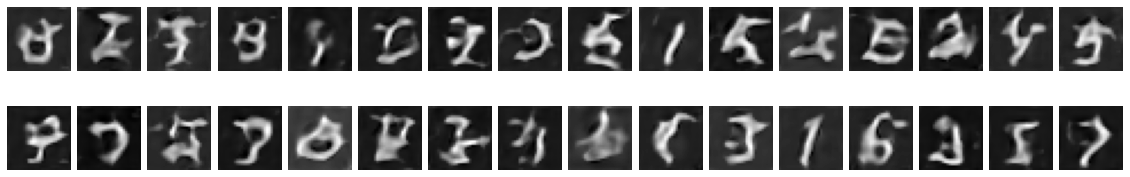

In [87]:
#run training loop
epochs = 10
losses = train(norm_ds, epochs)

In [88]:
#manual save
#checkpoint.save(file_prefix = checkpoint_prefix)

In [89]:
#restore last checkpoint
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Visualise outcome

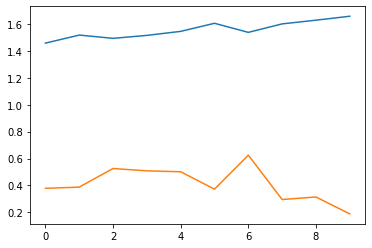

[<tf.Tensor: shape=(), dtype=float32, numpy=1.4574692>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5172787>, <tf.Tensor: shape=(), dtype=float32, numpy=1.4929899>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5150464>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5448978>, <tf.Tensor: shape=(), dtype=float32, numpy=1.6049005>, <tf.Tensor: shape=(), dtype=float32, numpy=1.5374906>, <tf.Tensor: shape=(), dtype=float32, numpy=1.6004586>, <tf.Tensor: shape=(), dtype=float32, numpy=1.6279926>, <tf.Tensor: shape=(), dtype=float32, numpy=1.6572449>] 

[<tf.Tensor: shape=(), dtype=float32, numpy=0.37897745>, <tf.Tensor: shape=(), dtype=float32, numpy=0.38782305>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5261631>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5086694>, <tf.Tensor: shape=(), dtype=float32, numpy=0.50192493>, <tf.Tensor: shape=(), dtype=float32, numpy=0.3725241>, <tf.Tensor: shape=(), dtype=float32, numpy=0.62508726>, <tf.Tensor: shape=(), dtype=float32, numpy=0.29577306>, <

In [90]:
#print losses
x = np.arange(0, epochs)
plt.plot(x, losses[0]) #blue    >discriminator loss
plt.plot(x, losses[1]) #orange  >generator loss
plt.show()
print(losses[0], "\n")
print(losses[1])

[ 0.7047996   2.4891946  -0.09178807  1.4515482 ]


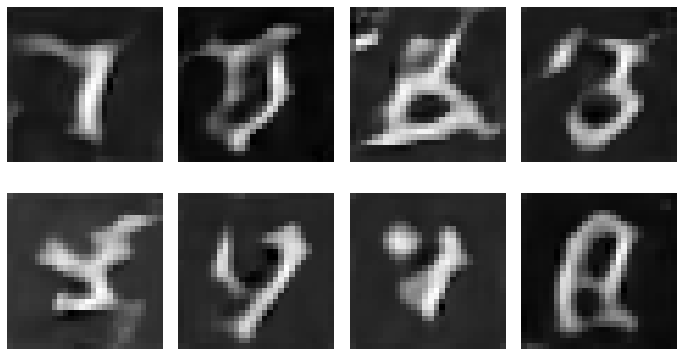

In [91]:
#inference
z = noiseList(batch_size)
print(z[0][0][0:4])
added_noise = tf.random.normal((batch_size, im_size, im_size, 1))
images = gen_model((z, added_noise))

fig = plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.subplots_adjust(hspace=-0.6, wspace=0.1)
plt.show()

In [92]:
#losses = train(norm_ds, 1)

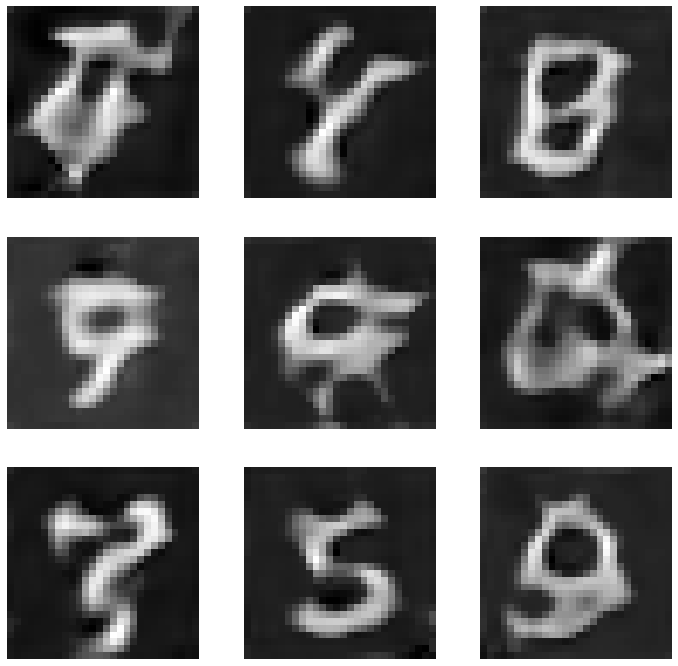

In [93]:
#check mode collapse
fig = plt.figure(figsize=(12,12))
for i in range(9):
    #generate new images every time
    z = noiseList(batch_size)
    added_noise = tf.random.normal((batch_size, im_size, im_size, 1))*1
    #images = gen_model((z, added_noise))
    w = []
    rand_num = np.random.uniform(low=-1, high=1)
    for z in z:
        z*=1
        new_w = S(z)
        #new_w *= rand_num
        w.append(new_w)
    #print(w)
    images = G((w, added_noise*1))
    
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

#plt.savefig("testing mode collapse")
plt.show()

In [94]:
#get some w
noise_list = []
for i in range(n_layers):
    noise_list.append(noise(1))
for z in noise_list:
    print(z[0][0])
    print(S(z)[0][0])

-1.7858824
tf.Tensor(-0.20342867, shape=(), dtype=float32)
2.0700588
tf.Tensor(-0.1364014, shape=(), dtype=float32)
-0.40014985
tf.Tensor(-0.10446539, shape=(), dtype=float32)
-0.42109874
tf.Tensor(-0.17081264, shape=(), dtype=float32)
-0.0678689
tf.Tensor(-0.06282158, shape=(), dtype=float32)
1.6440173
tf.Tensor(-0.09508916, shape=(), dtype=float32)
1.6053905
tf.Tensor(-0.1468853, shape=(), dtype=float32)
-0.16592745
tf.Tensor(-0.103209674, shape=(), dtype=float32)


In [95]:
#truncation trick
def truncate(style, psi=0.5):
    #get avg(w)
    w_avg = K.mean(style, axis=0)
    #print(w_avg)
    w_t = w_avg + psi*(style - w_avg)
    return w_t


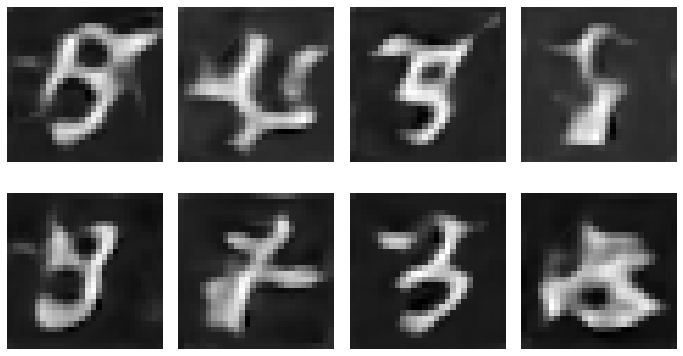

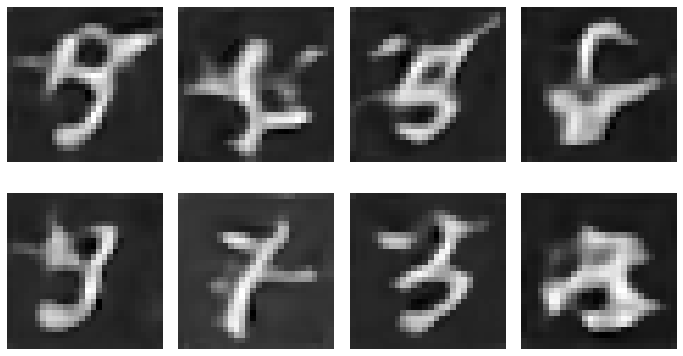

In [96]:
more_noise = tf.random.normal([batch_size, im_size, im_size, 1])

w = []
z = noiseList(batch_size)
for z in z:
    w.append(S(z))


images = G((w, more_noise))

fig = plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.subplots_adjust(hspace=-0.6, wspace=0.1)
plt.show()

truncated_w = []
for w in w:
    truncated_w.append(truncate(w, 0))
#print(truncated_w[0])
images = G((truncated_w, more_noise))

fig = plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.subplots_adjust(hspace=-0.6, wspace=0.1)
plt.show()

#print(images)